# Image Restoration with Metropolis MCMC

![Ising Model MRF](./figures/Ising_MRF.png "Ising Model MRF")

Let the $X$ be a $I \times J$ binary matrix that describes the observed noisy image where each $X_{ij}$ is either $+1$ or $-1$ (i.e. black or white). Our generative model assumes that there exists an unknown noise-free image $Z \in \{-1,1\}^{I \times J}$ which is generated from an Ising model and each pixel is flipped with a small probability $\pi$.

\begin{eqnarray}
Z \sim p(Z \mid \beta) \\
F_{ij} \sim \text{Be}(\pi) \\
X_{ij} = (-1)^{F_{ij}} Z_{ij} \\
\end{eqnarray}

where

\begin{eqnarray}
p(Z \mid \beta) & \propto & e^{-E(Z \mid \beta)} \\
E(Z \mid \beta) & = & - \beta \sum_{(i,j)\sim (k,l)} Z_{ij} Z_{kl}
\end{eqnarray}

Here, the summation is over the all connected pairs of $Z_{ij}$ and $Z_{kl}$.

## Ising Model Simulation

Typical samples drawn from the Ising model while increasing the inverse temperature parameter $\beta$.

![Ising Model Simulation](./figures/Ising.gif "Ising Model Simulation")

## Posterior Distribution of $Z$

\begin{eqnarray}
p(Z \mid X, \beta, \pi) & = & \frac{p(Z, X \mid \beta, \pi)}{p(X \mid \beta, \pi)} \\
& \propto & p(Z, X \mid \beta, \pi) \\
& = & p(Z \mid \beta) p(X \mid Z, \pi) \\
& \propto & \exp{\left(\beta \sum_{(i,j)\sim (k,l)} Z_{ij} Z_{kl} \right)}
\prod_{ij} \pi^{(1 - X_{ij}Z_{ij})/2} (1-\pi)^{(X_{ij}Z_{ij} + 1)/2} \\
& \propto & \exp{\left( \gamma \sum_{ij} Z_{ij} X_{ij} + \beta \sum_{(i,j)\sim (k,l)} Z_{ij} Z_{kl} \right)}
\end{eqnarray}

where $\gamma = \dfrac{1}{2} \log{\dfrac{1-\pi}{\pi}}$, but from now on instead of $\pi$ we will use the parametrization with $\gamma$.

## Sampling from the Posterior

We will design a Markov chain whose stationary distribution is the posterior distribution of $Z$. Following Metropolis-Hastings algorithm with the symmetric proposal $q(Z' \mid Z)$ should work:

Initialize $Z^{(0)} \gets X$ and at time step $t$:
* Randomly choose a pixel $(i,j)$.
* Propose a bit flip on $Z^{(t)}_{ij}$, i.e. $Z'_{ij} \gets -Z^{(t)}_{ij} $.
* Calculate acceptance probability 
$\alpha^{(t)} = \min\left\{ 1 , \frac{q(Z^{(t)} \mid Z') p(Z' \mid X, \beta, \pi)}{q(Z' \mid Z^{(t)}) p(Z^{(t)} \mid X, \beta, \pi)} \right\} = \min\left\{ 1 , \frac{p(Z' \mid X, \beta, \pi)}{p(Z^{(t)} \mid X, \beta, \pi)} \right\}$
* $Z^{(t+1)} \gets Z'$, with probability $\alpha^{(t)}$
* $Z^{(t+1)} \gets Z^{(t)}$, otherwise

### Acceptance Probability

Calculating the posterior distributions from scratch is extremely inefficient, because at each time step only a pixel of the $Z$ is changing. Hence, the posterior distributions of $Z$ and $Z'$ have lots of common terms. Assume a bit flip is proposed in pixel $(i,j)$ at time step $t$, then

\begin{eqnarray}
\alpha^{(t)} 
& = & 
\frac{\exp{\left( \gamma Z'_{ij} X_{ij} + \beta \sum_{(i,j) \sim (k,l)} Z'_{ij} Z'_{kl} \right)}}
{\exp{\left( \gamma Z^{(t)}_{ij} X_{ij} + \beta \sum_{(i,j) \sim (k,l)} Z^{(t)}_{ij} Z^{(t)}_{kl} \right)}} \\
& = & 
\frac{\exp{\left( - \gamma Z^{(t)}_{ij} X_{ij} - \beta \sum_{(i,j) \sim (k,l)} Z^{(t)}_{ij} Z^{(t)}_{kl} \right)}}
{\exp{\left( \gamma Z^{(t)}_{ij} X_{ij} + \beta \sum_{(i,j) \sim (k,l)} Z^{(t)}_{ij} Z^{(t)}_{kl} \right)}} \\
& = & 
\exp{\left( - 2\gamma Z^{(t)}_{ij} X_{ij} - 2\beta \sum_{(i,j) \sim (k,l)} Z^{(t)}_{ij} Z^{(t)}_{kl} \right)}
\end{eqnarray}

Notice that, the summation is over the all the pixels $Z_{kl}$ that are connected to a fixed $Z_{ij}$. 

## Example

In [1]:
%matplotlib inline
import numpy as np
from scipy.ndimage import imread

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 6
sns.set_style("white")

np.set_printoptions(precision=2,suppress=True)

### Original Image

In [3]:
img = imread('./figures/lena.png',mode='L')
img = 2*(img > 127).astype(int)-1

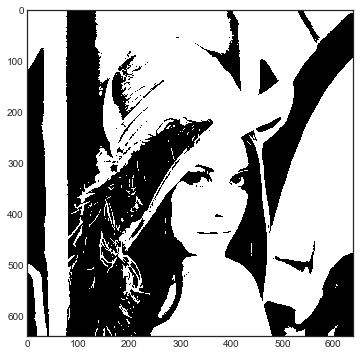

In [4]:
plt.imshow(img,cmap='gray',vmin=-1,vmax=1)
plt.show()

### Noisy Image

In [5]:
pi = 0.15
I,J = img.shape
flip = np.random.rand(I,J) < pi
X = img * (-1)**flip

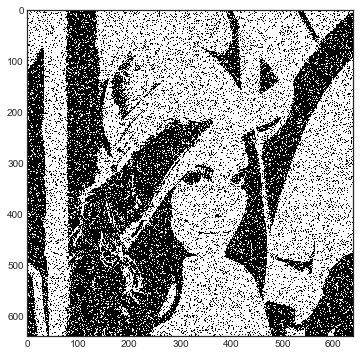

In [6]:
plt.imshow(X,cmap='gray',vmin=-1,vmax=1)
plt.show()

## Image Denoising

We will sample a $Z$ from the posterior distribution. Hopefully, it will appear as denoised.

In [7]:
gamma, beta = 2.0, 0.8 # for arbitrary parameters that reflects our prior belief
T = 5000000 # sufficient number of steps to converge stationary distribution

In [8]:
Z = X.copy() # Initialize Z from X 
for t in range(T):
    i,j = np.random.choice(I), np.random.choice(J) # randomly choose a coordinate (i,j)
    delta_E = -2*gamma*X[i,j]*Z[i,j] -2*beta*Z[i,j]*(np.sum(Z[max(i-1,0):i+2,max(j-1,0):j+2]) - Z[i,j])
    if np.log(np.random.rand()) < delta_E:
        Z[i,j] = - Z[i,j] 

## Result

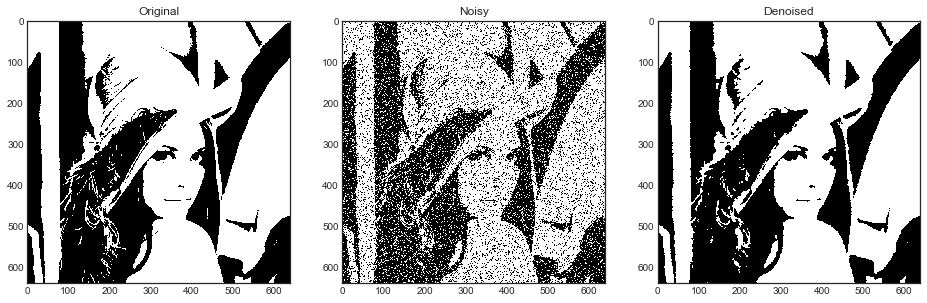

In [9]:
fig, ax = plt.subplots(1,3, figsize=(16,8))
ax[0].imshow(img,cmap='gray',vmin=-1,vmax=1)
ax[0].set_title("Original")
ax[1].imshow(X,cmap='gray',vmin=-1,vmax=1)
ax[1].set_title("Noisy")
ax[2].imshow(Z,cmap='gray',vmin=-1,vmax=1)
ax[2].set_title("Denoised")
plt.show()